Best has 4 Gaussian components with
Weight:  0.1925562492237863
Mean:  [-1.94638747  3.78540856]
Covariance: [[ 2.34022  -0.54911]
             [-0.54911   2.08492 ]]
Weight:  0.37943817839994315
Mean:  [ 0.04013919 -2.09547369]
Covariance: [[ 1.92192   -0.412832]
             [-0.412832   1.40911 ]]
Weight:  0.2525720259524252
Mean:  [2.89195144 3.61772663]
Covariance: [[10.3255    0.482847]
             [ 0.482847  3.15633 ]]
Weight:  0.17543354642384532
Mean:  [ 3.92733518 -1.69531149]
Covariance: [[ 6.10091   -0.596302]
             [-0.596302   8.93782 ]]


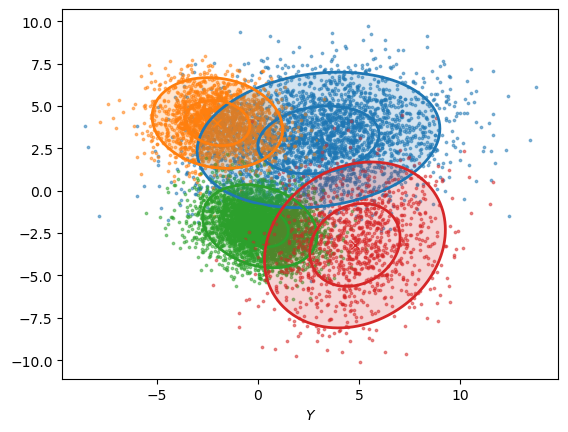

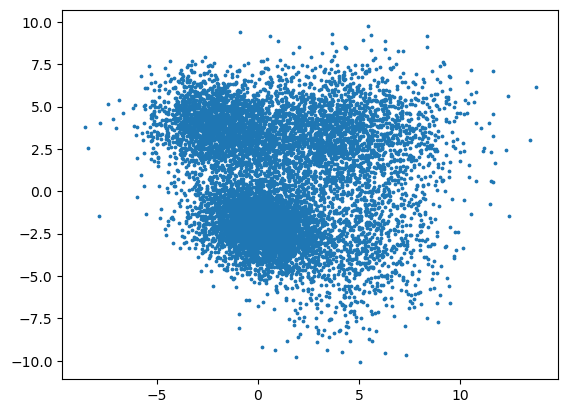

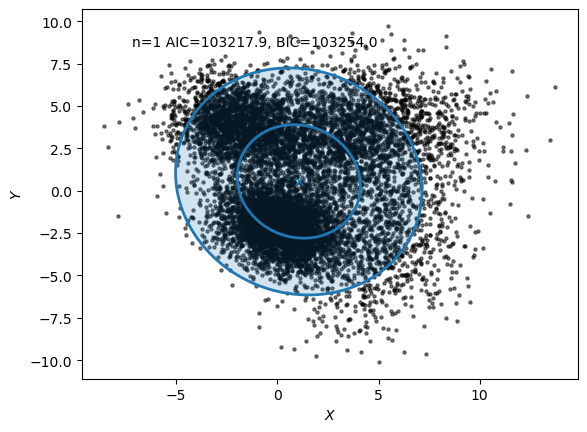

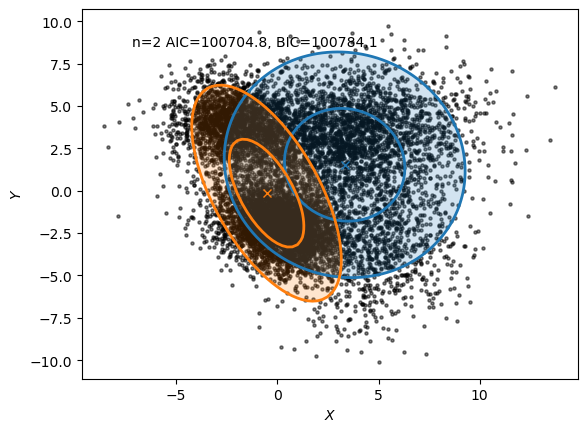

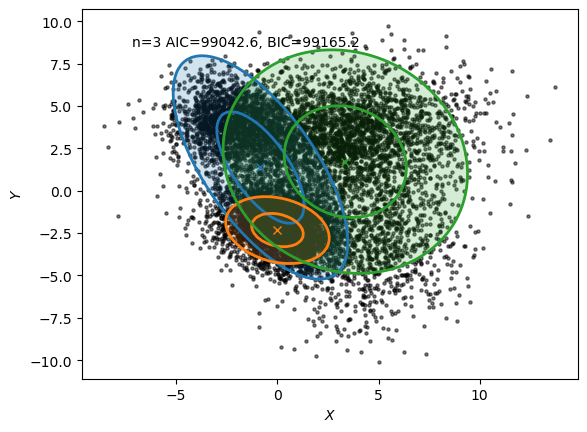

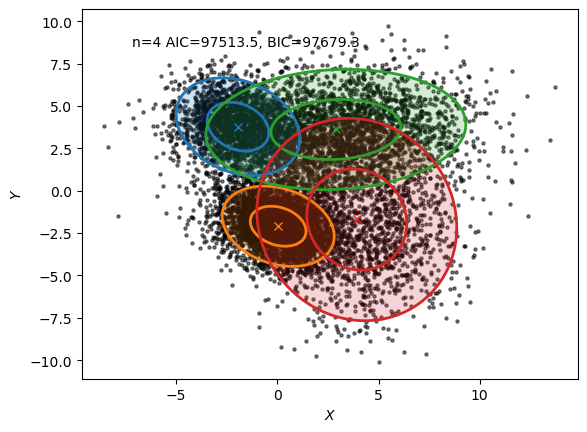

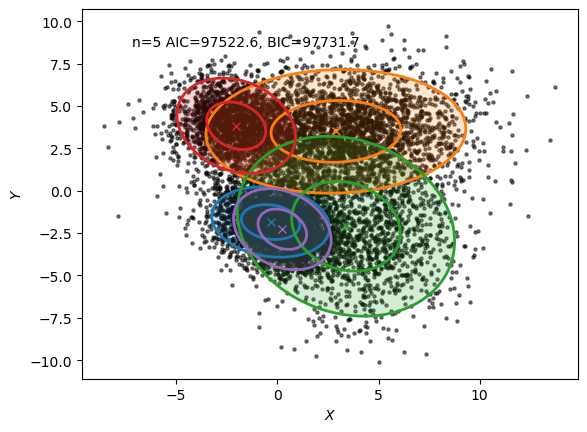

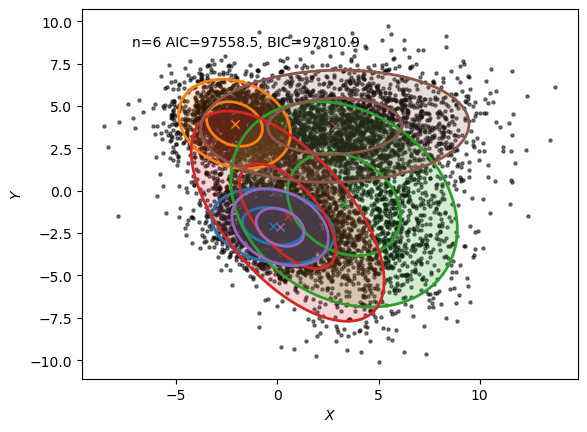

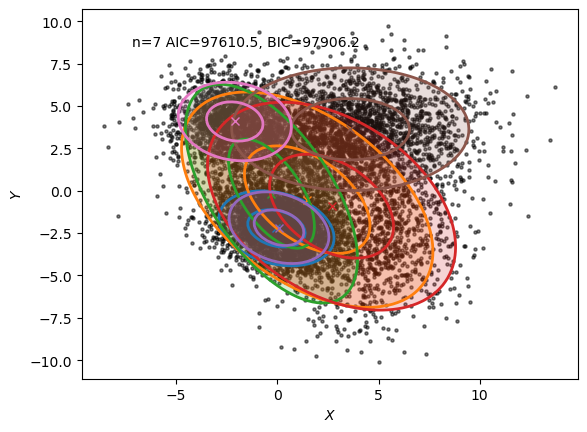

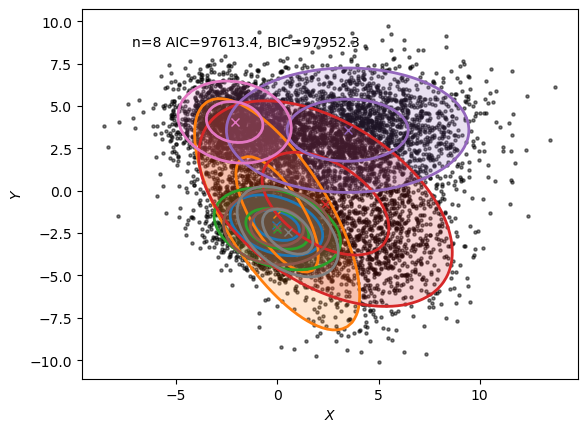

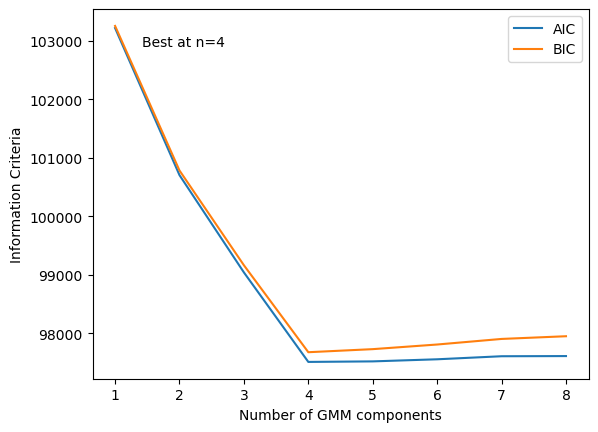

In [2]:
import os
import numpy as np
np.random.seed(210187)
from scipy.stats import multivariate_normal as mvn
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from tabulate import tabulate

os.system("mkdir -p figs")

# I'm going to use 4 underlying Gaussians
m1 = [3, 3]
c1 = [[9,1],[1,4]]

m2 = [-2,4]
c2 = [[2.6,-0.3],[-0.3,1.8]]

m3 = [0.1,-2.1]
c3 = [[2,-0.4],[-0.4,1.5]]

m4 = [4.8,-3.2]
c4 = [[5,1],[1,6]]

mvn1 = mvn(mean=m1, cov=c1)
mvn2 = mvn(mean=m2, cov=c2)
mvn3 = mvn(mean=m3, cov=c3)
mvn4 = mvn(mean=m4, cov=c4)

f1 = 0.3
f2 = 0.2
f3 = 0.4

N = 10000

N1 = int(f1*N)
N2 = int(f2*N)
N3 = int(f3*N)
N4 = N - N1 - N2 - N3

N1 = np.random.poisson(N1)
N2 = np.random.poisson(N2)
N3 = np.random.poisson(N3)
N4 = np.random.poisson(N4)

dset1 = mvn1.rvs( size=N1 )
dset2 = mvn2.rvs( size=N2 )
dset3 = mvn3.rvs( size=N3 )
dset4 = mvn4.rvs( size=N4 )

dset = np.concatenate( [dset1, dset2, dset3, dset4] )
np.save( 'gmm.npy', dset )

def draw_mvn( mv, ax=None, **kwargs ):
    ax = ax or plt.gca()

    x = np.linspace( *ax.get_xlim(), 100 )
    y = np.linspace( *ax.get_ylim(), 100 )
    
    X, Y = np.meshgrid(x, y)
    X, Y = X.T, Y.T
    pos = np.dstack((X,Y))

    lnZ = 2 * ( mv.logpdf( mv.mean ) - mv.logpdf(pos) )
    ax.contourf(X, Y, lnZ, levels=[0,1,4], alpha=0.2, **kwargs )
    ax.contour(X, Y, lnZ, levels=[1,4], linewidths=2, **kwargs )
    ax.plot(mv.mean[0], mv.mean[1], marker='x', c=kwargs['colors'])

def run_gmm( dset, n_components, means_init=None ):
    if means_init is None:
        means_init = [ np.mean(dset, axis=0) ]*n_components

    gmm = GaussianMixture( n_components=n_components, means_init=means_init )
    gmm.fit(dset)
    
    fig, ax = plt.subplots()
    ax.scatter( dset[:,0], dset[:,1], s=5, fc='k', ec='k', alpha=0.5 )

    for ig in range(n_components):
        mean = gmm.means_[ig]
        covs = gmm.covariances_[ig]
        fmvn = mvn(mean, covs)
        draw_mvn( fmvn, colors=f'C{ig}', ax=ax )

    ax.text( 0.1, 0.9, f'n={n_components} AIC={gmm.aic(dset):.1f}, BIC={gmm.bic(dset):.1f}', transform=ax.transAxes )
    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    fig.savefig(f'figs/gmm_ncomp{n_components}.pdf')
    return gmm

# distribution of truth and plain scatter
fig, ax = plt.subplots()
ax.scatter( dset1[:,0], dset1[:,1], s=3, alpha=0.5 ) 
ax.scatter( dset2[:,0], dset2[:,1], s=3, alpha=0.5 ) 
ax.scatter( dset3[:,0], dset3[:,1], s=3, alpha=0.5 ) 
ax.scatter( dset4[:,0], dset4[:,1], s=3, alpha=0.5 )
draw_mvn( mvn1, ax, colors='C0' )
draw_mvn( mvn2, ax, colors='C1' )
draw_mvn( mvn3, ax, colors='C2' )
draw_mvn( mvn4, ax, colors='C3' )
ax.set_xlabel('$X$')
ax.set_xlabel('$Y$')
fig.savefig('gmm_truth.pdf')

fig, ax = plt.subplots()
ax.scatter( dset[:,0], dset[:,1], s=3 )
fig.savefig('gmm_scatter.pdf')

# now run a few different efforts
ncomps = np.arange(1,9)
aics = []
bics = []
weights = []
means = []
covs  = []
for ncomp in ncomps:
    gmm = run_gmm( dset, n_components=ncomp )
    aics.append( gmm.aic(dset) )
    bics.append( gmm.bic(dset) )
    weights.append( gmm.weights_ )
    means.append( gmm.means_ )
    covs.append( gmm.covariances_ )

fig, ax = plt.subplots()
ax.plot( ncomps, aics, label='AIC' )
ax.plot( ncomps, bics, label='BIC' )
ax.set_xlabel('Number of GMM components')
ax.set_ylabel('Information Criteria')

nbest = ncomps[ np.argmin(bics) ]
ax.text(0.1, 0.9, f'Best at n={nbest}', transform=ax.transAxes )
ax.legend()
fig.savefig('gmm_information.pdf')

# print the best outcome
print(f'Best has {nbest} Gaussian components with')
for i in range(nbest):
    print('Weight: ', weights[nbest-1][i] )
    print('Mean: ', means[nbest-1][i] )
    print('Covariance: [[', end='')
    print(tabulate( covs[nbest-1][i], tablefmt='plain' ).replace('\n',']\n             [')+' ]]')

# plt.show()